In [2]:
import json
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager


In [4]:
# Initialize Chrome options
options = webdriver.ChromeOptions()
#options.add_argument('--headless')  # Optional: Run in headless mode

# Set logging preferences to capture only browser logs
options.set_capability(
    'goog:loggingPrefs', {"performance":"ALL","browser": "ALL"}  # Excluded "performance" logs
)
options.add_experimental_option("prefs", {
    "profile.default_content_setting_values.cookies": 1,  # Allow all cookies
    "profile.default_content_setting_values.automatic_downloads": 1,
    "profile.default_content_setting_values.images": 1,
})

# Initialize the Chrome WebDriver with webdriver_manager
service = ChromeService(ChromeDriverManager().install())

In [6]:
#get the average locations
try:
    driver = webdriver.Chrome(
        service=service,
        options=options
    )

    # Navigate to a webpage
    driver.get('https://www.sofascore.com/football/match/galatasaray-antalyaspor/glbsllb#id:12530886,tab:lineups')
except:
    pass

In [4]:
#before you run the next cells, you need to go to

In [8]:
driver.execute_script("window.scrollTo(0,document.body.scrollHeight);")

In [10]:
logs_raw = driver.get_log("performance")
logs = [json.loads(lr['message'])['message'] for lr in logs_raw]

for x in logs:
    if 'average-positions' in x['params'].get('headers',{}).get(':path', ''):
        #print(x['params'].get('headers',{}).get(':path', ''))
        avgPosLog = x
    elif 'lineups' in x['params'].get('headers',{}).get(':path', ''):
        #print(x['params'].get('headers',{}).get(':path', ''))
        lineupLog = x

In [12]:
# In this RFS game Galatasaray was the away team...
response_body = driver.execute_cdp_cmd('Network.getResponseBody', {'requestId': avgPosLog['params']['requestId']})
dataPos = json.loads(response_body['body'])['away']

response_body = driver.execute_cdp_cmd('Network.getResponseBody', {'requestId': lineupLog['params']['requestId']})
dataLineup = json.loads(response_body['body'])

In [14]:
for player_info in dataLineup['away']['players']:
    # Now, access the 'player' key from each dictionary
    print(player_info['shirtNumber'])

1
23
6
42
4
34
20
7
10
11
9
18
22
53
44
45
19
25
90
5
83


In [16]:
import pandas as pd

players =  []
fullName= []
average_x = []
average_y = []
points = []
jerseyNo = []
position = []
for man in dataPos:
    #player = 
    players.append(man['player']['slug'])
    fullName.append(man['player']['name'])
    #jerseyNo.append(man['shirtNumber'])
    position.append(man['player']['position'])
    average_x.append(man['averageX'])
    average_y.append(man['averageY'])
    points.append(man['pointsCount'])
    for player_info in dataLineup['away']['players']:
    # Now, access the 'player' key from each dictionary
        if player_info['player']['slug'] == man['player']['slug']:
            jerseyNo.append(player_info['shirtNumber'])
    

In [18]:
position_data = {'player': players, 'fullName':fullName, 'position': position, 'jersey': jerseyNo ,'x': average_x, 'y':average_y, 'points': points}
df_posData = pd.DataFrame(position_data)
print(df_posData)

                 player             fullName position  jersey          x  \
0        victor-osimhen       Victor Osimhen        F      45  83.050000   
1           yunus-akgun          Yunus Akgün        F      11  61.334545   
2         dries-mertens        Dries Mertens        M      10  60.723404   
3          mauro-icardi         Mauro Icardi        F       9  69.272727   
4   abdulkerim-bardakci  Abdülkerim Bardakcı        D      42  29.090000   
5         ismail-jakobs        Ismail Jakobs        D       4  59.979167   
6    baris-alper-yilmaz   Barış Alper Yılmaz        F      53  41.270588   
7          hakim-ziyech         Hakim Ziyech        M      22  68.742857   
8       michy-batshuayi      Michy Batshuayi        F      44  48.366667   
9         roland-sallai        Roland Sallai        F       7  59.296053   
10           kaan-ayhan           Kaan Ayhan        D      23  42.733333   
11         gabriel-sara         Gabriel Sara        M      20  47.956522   
12       luc

In [ ]:
jerseyNo

In [38]:
subs

['berkan-kutlu',
 'hakim-ziyech',
 'baris-alper-yilmaz',
 'michy-batshuayi',
 'victor-osimhen',
 'gunay-guvenc',
 'victor-nelsson',
 'metehan-baltaci',
 'eyup-aydin',
 'efe-akman']

In [42]:
subs = []
for man in dataLineup['away']['players']:
    if man['substitute'] is True:
        subs.append(man['player']['slug'])


subs.remove('berkan-kutlu')
subs.append('ismail-jakobs')
        

strings_to_match = subs
df_posDataXI = df_posData[~df_posData['player'].isin(strings_to_match)] #keep the average position data of only the starters
df_posDataX = df_posDataXI[df_posData['position']!='G']

In [44]:
df_posDataX

,player,fullName,position,jersey,x,y,points
1,yunus-akgun,Yunus Akgün,F,11,61.334545,66.620000,55
2,dries-mertens,Dries Mertens,M,10,60.723404,47.559574,47
3,mauro-icardi,Mauro Icardi,F,9,69.272727,53.663636,22
4,abdulkerim-bardakci,Abdülkerim Bardakcı,D,42,29.090000,69.580000,80
9,roland-sallai,Roland Sallai,F,7,59.296053,30.993421,76
10,kaan-ayhan,Kaan Ayhan,D,23,42.733333,13.731481,54
11,gabriel-sara,Gabriel Sara,M,20,47.956522,57.492754,69
12,lucas-torreira,Lucas Torreira,M,34,44.159036,43.081928,83
13,davinson-sanchez,Davinson Sánchez,D,6,30.612329,37.290411,73
14,berkan-kutlu,Berkan Kutlu,M,18,41.396923,83.758462,65


In [46]:
highestPlayer = df_posDataX.loc[df_posDataX['x'].idxmax(), 'fullName']
deepestPlayer = df_posDataX.loc[df_posDataX['x'].idxmin(), 'fullName']

In [58]:
team_height = df_posDataX['x'].max() - df_posDataX['x'].min()
height = round(team_height,1)*105/100

team_width = df_posDataX['y'].max() - df_posDataX['y'].min()
width = round(team_width,1)*68/100

offSpace = 100 - df_posDataX['x'].max()
offSpace = round(offSpace,1)*105/100

defSpace = df_posDataX['x'].min()
defSpace = round(defSpace,1)*105/100

In [60]:
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
import matplotlib.font_manager as font_manager
import matplotlib.image as mpimg
from PIL import Image

font_path = 'C:/Users/egeki/Downloads/Arvo/Arvo-Regular.ttf'
font_props = font_manager.FontProperties(fname=font_path)
background_color = '#0C0D0E'

In [52]:
pitch = VerticalPitch(
    pitch_type='opta', 
    pitch_color=background_color,
    pad_bottom=.5, 
    line_color='white',
    linewidth=3,
    axis=False, label=False,
)

In [54]:
#logos
# Load a PNG image from a file
antalya_path = r'C:\Users\egeki\OneDrive\Masaüstü\football\pitchParcelization\antalya.png'
gs_path = r'C:\Users\egeki\OneDrive\Masaüstü\football\pitchParcelization\gs.png'

antalya_logo = Image.open(antalya_path)
gs_logo = Image.open(gs_path)

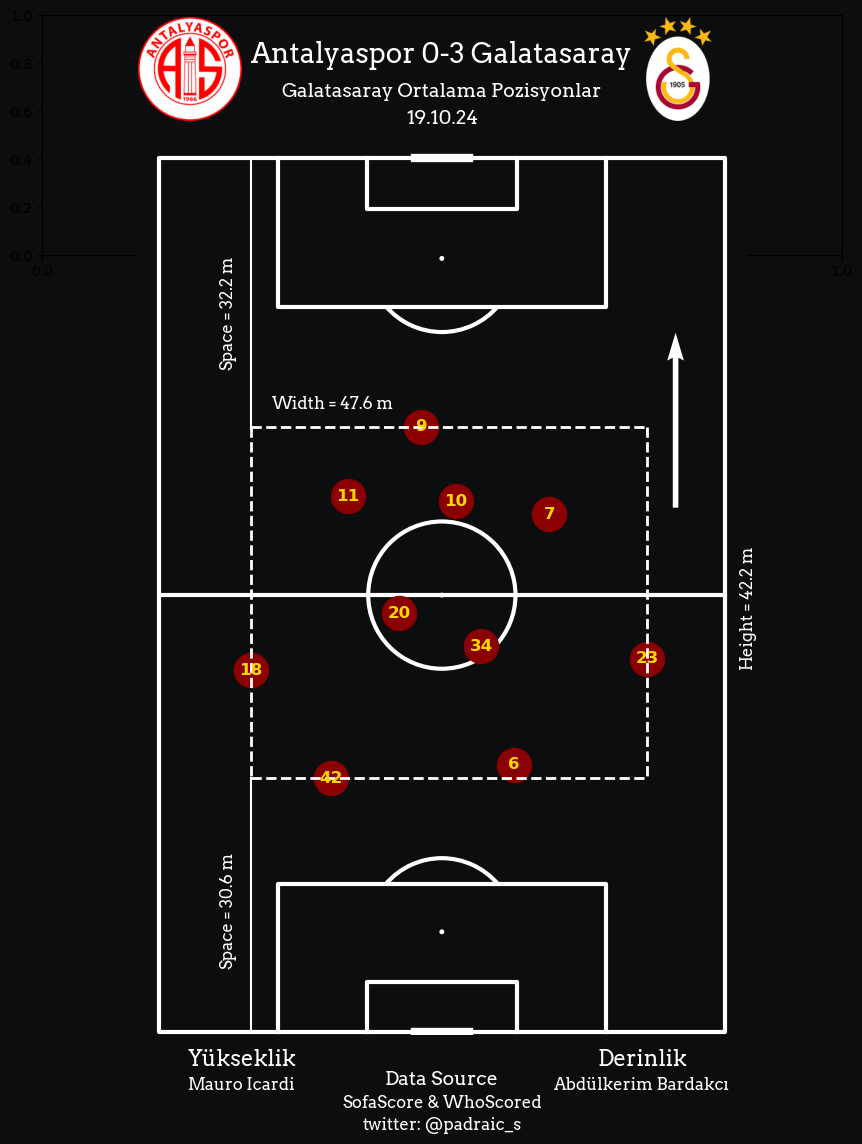

In [80]:
fig = plt.figure(figsize=(8,12))
fig.patch.set_facecolor(background_color)

ax1 = fig.add_axes([0, 0.7, 1, .2])
ax1.set_facecolor(background_color)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax1.text(
    x=0.5, 
    y=.8, 
    s='Antalyaspor 0-3 Galatasaray', 
    fontsize=20, 
    fontproperties=font_props, 
    fontweight='bold', 
    color='white', 
    ha='center'
)

ax1.text(
    x=0.5, 
    y=.66, 
    s=f'Galatasaray Ortalama Pozisyonlar', 
    fontsize=14,
    fontweight='bold',
    fontproperties=font_props, 
    color='white', 
    ha='center'
)
ax1.text(
    x=0.5, 
    y=.55, 
    s=f'19.10.24', 
    fontsize=14,
    fontweight='bold',
    fontproperties=font_props, 
    color='white', 
    ha='center'
)

kit_no_size=12
ax2 = fig.add_axes([.05, .05, 0.9, .75])
pitch.draw(ax=ax2)
for coord in df_posDataX.to_dict(orient='records'):
    pitch.scatter(coord['x'], coord['y'], s=600, color='#8B0000',ax=ax2)
    pitch.text(coord['x'], coord['y'], coord['jersey'],ha='center', va='center',color='#FFD700',size = kit_no_size,fontweight='bold', ax=ax2)


x_coords = [df_posDataX['y'].max(),df_posDataX['y'].min()]
y_coords = [df_posDataX['x'].min(),df_posDataX['x'].min()]
ax2.plot(x_coords, y_coords, color='white', linewidth=2, linestyle="--")
x_coords = [df_posDataX['y'].max(),df_posDataX['y'].min()]
y_coords = [df_posDataX['x'].max(),df_posDataX['x'].max()]
ax2.plot(x_coords, y_coords, color='white', linewidth=2, linestyle="--")

x_coords = [df_posDataX['y'].max(),df_posDataX['y'].max()]
y_coords = [df_posDataX['x'].max(),df_posDataX['x'].min()]
ax2.plot(x_coords, y_coords, color='white', linewidth=2, linestyle="--")
x_coords = [df_posDataX['y'].min(),df_posDataX['y'].min()]
y_coords = [df_posDataX['x'].max(),df_posDataX['x'].min()]
ax2.plot(x_coords, y_coords, color='white', linewidth=2, linestyle="--")

ax2.text(
        x=df_posDataX['x'].max(),
        y=df_posDataX['x'].max()+2,
        s=f'Width = {width:.1f} m', 
        fontsize=12,
        fontweight='bold',
        fontproperties=font_props, 
        color='white', 
        ha='center')
ax2.text(
        x=-4,
        y=df_posDataX['x'].mean(),
        s=f'Height = {height:.1f} m', 
        fontsize=12,
        fontweight='bold',
        fontproperties=font_props, 
        color='white', 
        ha='center',
        va='center',
        rotation=90)

pitch.arrows(60,df_posDataX['y'].min()-5,80,df_posDataX['y'].min()-5,color="white",linewidth=3,ax=ax2)

#plot the space we leave up front
x_coords = [df_posDataX['y'].max(),df_posDataX['y'].max()]
y_coords = [df_posDataX['x'].max(),100]
ax2.plot(x_coords,y_coords,color='white')
ax2.text(
        x=df_posDataX['y'].max()+4,
        y=df_posDataX['x'].max()+7,
        s=f'Space = {offSpace:.1f} m', 
        fontsize=12,
        fontweight='bold',
        fontproperties=font_props, 
        color='white', 
        ha='center',
        rotation=90)

#plot the space we leave up behind while with the ball
x_coords = [df_posDataX['y'].max(),df_posDataX['y'].max()]
y_coords = [0,df_posDataX['x'].min()]
ax2.plot(x_coords,y_coords,color='white')
ax2.text(
        x=df_posDataX['y'].max()+4,
        y=df_posDataX['y'].min()-6,
        s=f'Space = {defSpace:.1f} m', 
        fontsize=12,
        fontweight='bold',
        fontproperties=font_props, 
        color='white', 
        ha='center',
        rotation=90)

ax3 = fig.add_axes([0, 0, 1, .05])
ax3.set_facecolor(background_color)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

ax3.text(
    x=0.25, 
    y=.5, 
    s=f'Yükseklik', 
    fontsize=16, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)
ax3.text(
    x=0.25, 
    y=.1, 
    s=highestPlayer, 
    fontsize=12, 
    fontproperties=font_props,
    color='white', 
    ha='center'
)

ax3.text(
    x=0.75, 
    y=.5, 
    s=f'Derinlik', 
    fontsize=16, 
    fontproperties=font_props, 
    fontweight='bold', 
    color='white', 
    ha='center'
)

ax3.text(
    x=0.75, 
    y=.1, 
    s=deepestPlayer, 
    fontsize=12, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)

ax3.text(
    x=0.5, 
    y=0.18, 
    s='Data Source', 
    fontsize=14, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)

ax3.text(
    x=0.5, 
    y=-0.2, 
    s='SofaScore & WhoScored', 
    fontsize=12, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)

ax3.text(
    x=0.5, 
    y=-.58, 
    s='twitter: @padraic_s', 
    fontsize=12, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)

ax3.axis('off') 

ax4 = fig.add_axes([.12,.79,.13,.13])
ax4.axis('off')
img = Image.open(antalya_path)
ax4.imshow(img)

ax5 = fig.add_axes([.73,.79,.13,.13])
ax5.axis('off')
img = Image.open(gs_path)
ax5.imshow(img)



In [88]:
# Save the figure
fig.savefig(r'C:\Users\egeki\OneDrive\Masaüstü\football\pitchParcelization\Antalya_Gs.png', facecolor=background_color, bbox_inches='tight', dpi=600)